<a href="https://colab.research.google.com/github/ehtisham-Fazal/ACP_KSRC/blob/main/new_results_ACP_SRC_740_Python_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import sys, os, re, gc
import numpy as np
import pandas as pd
from random import sample

## Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Dropout
from keras import metrics
from keras import optimizers
from keras.utils.np_utils import to_categorical

import numpy.linalg as LA
from sklearn.model_selection import train_test_split

## Perfmetrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, matthews_corrcoef, balanced_accuracy_score, precision_recall_fscore_support
from sklearn.metrics import auc, average_precision_score, precision_recall_curve, roc_curve,roc_auc_score


## utilities
from matplotlib import pyplot as plt
!pip install wget
import wget


## pre-processing
from sklearn.preprocessing import normalize, Normalizer
from sklearn.decomposition import KernelPCA
from imblearn.over_sampling import ADASYN, SMOTE, SVMSMOTE, KMeansSMOTE, BorderlineSMOTE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
file1_path = 'https://raw.githubusercontent.com/NLPrinceton/sparse_recovery/master/solvers.py'
wget.download(file1_path, 'solvers.py')
from solvers import *

dataset_path='http://www.cczubio.top/static/ACP-check/datasets/ACP-DL/acp740.txt'
wget.download(dataset_path, 'acp740.txt')

'acp740.txt'

In [3]:
def prepare_feature_acp740():
    path = r"acp740.txt"
    new_list=[]
    seq_list=[]
    label = []
    lis = []
    lx=[]
    interaction_pair = {}
    RNA_seq_dict = {}
    protein_seq_dict = {}
    protein_index = 0
    with open(path, 'r') as fp:
        for line in fp:
            if line[0] == '>':
                values = line[1:].strip().split('|')
                label_temp = values[1]            
                proteinName = values[0]
                proteinName_1=proteinName.split("_")
                new_list.append(proteinName_1[0])   

                if label_temp == '1':
                    label.append(1)
                else:
                    label.append(0)
            else:
                seq = line[:-1]
                seq_list.append(seq)
        for i, item in enumerate(new_list):
            lis.append([item, seq_list[i]])
        for i in lis:
            if len(i[1])>60:
                x=([i[0],i[1][0:60]])
                lx.append(x)
            else:
                lx.append(i)        
    return lx 
 



In [4]:
def yoden_index(y, y_pred):
  epsilon = 1e-30
  tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=[0,1]).ravel()
  j = (tp/(tp + fn + epsilon)) + (tn/(tn+fp + epsilon)) - 1
  return j

def pmeasure(y, y_pred):
    epsilon = 1e-30
    tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=[0,1]).ravel()
    sensitivity = tp / (tp + fn + epsilon)
    specificity = tn / (tn + fp + epsilon)
    f1score = (2 * tp) / (2 * tp + fp + fn + epsilon)
    return ({'Sensitivity': sensitivity, 'Specificity': specificity, 'F1-Score': f1score})
    
def Calculate_Stats(y_actual,y_pred):
  acc = accuracy_score(y_actual, y_pred)
  sen = pmeasure(y_actual, y_pred)['Sensitivity']
  spe = pmeasure(y_actual, y_pred)['Specificity']
  f1 = pmeasure(y_actual, y_pred)['F1-Score']
  mcc = matthews_corrcoef(y_actual, y_pred)
  bacc = balanced_accuracy_score(y_actual, y_pred)
  yi = yoden_index(y_actual, y_pred)
  
  return acc, sen, spe, f1, mcc, bacc, yi

In [5]:
def Test_SRC(A,delta_y,DATA,LABEL,solver='BP',verbose=0, x0=None, ATinvAAT=None, nnz=None, positive=False, tol=1E-4, niter=100, biter=32):
  import time
  LABEL_PRED = []
  SCORE_PRED=[]
  count = 0
  time_ellapsed = []
  for ind in range(0,DATA.shape[1]):
    start_time = time.time()
    b = DATA[:,ind]
    if(solver=='BP'):     
      x = BasisPursuit(A, b, x0=x0, ATinvAAT=ATinvAAT, positive=positive, tol=tol, niter=niter, biter=biter)
    elif(solver=='MP'):      
      x = MatchingPursuit(A, b, tol=tol, nnz=nnz, positive=positive)
 
    label_out, score_out = delta_rule(A,delta_y,x,b)
    time_ellapsed.append(time.time()-start_time)
    if (verbose):
      check = label_out==LABEL[ind]
      if (check):
        count = count + 1
      accuracy = 100*count/(ind+1)
      print(ind+1, count, accuracy, LABEL[ind], label_out, check)
    LABEL_PRED.append(label_out)
    SCORE_PRED.append(score_out)

  return np.array(LABEL_PRED), np.array(SCORE_PRED),np.array(time_ellapsed )

In [6]:
def delta_rule(A,delta_y,x,b):
  delta1 = 0*x
  delta2 = 0*x
  delta1[delta_y==1]=x[delta_y==1]
  delta2[delta_y==0]=x[delta_y==0]
  y1 = np.matmul(A,delta1)
  y2 = np.matmul(A,delta2)
  r1 = np.linalg.norm(y1-b)
  r2 = np.linalg.norm(y2-b)

  if(r1<r2):
    label = 1
  else:
    label = 0
  score=(r2)/(r1+r2)

  return label, score


In [7]:
def Convert_Seq2CKSAAP(train_seq, gap=8):
  cksaapfea = []
  seq_label = []
  for sseq in train_seq:
    temp= CKSAAP([sseq], gap=8)
    cksaapfea.append(temp[1][1:])
    seq_label.append(sseq[0])

  x = np.array(cksaapfea)
  y = np.array(seq_label)
  y[y=='ACP']=1
  y[y=='non-ACP']=0
  y = to_categorical(y)
  print('num pos:', sum(y[:,0]==1), 'num neg:', sum(y[:,0]==0))
  return x,y

def minSequenceLength(fastas):
    minLen = 10000
    for i in fastas:
        if minLen > len(i[1]):
            minLen = len(i[1])
    return minLen

def CKSAAP(fastas, gap=5, **kw):
    if gap < 0:
        print('Error: the gap should be equal or greater than zero' + '\n\n')
        return 0

    if minSequenceLength(fastas) < gap+2:
        print('Error: all the sequence length should be larger than the (gap value) + 2 = ' + str(gap+2) + '\n' + 'Current sequence length ='  + str(minSequenceLength(fastas)) + '\n\n')
        return 0

    AA = 'ACDEFGHIKLMNPQRSTVWY'
    encodings = []
    aaPairs = []
    for aa1 in AA:
        for aa2 in AA:
            aaPairs.append(aa1 + aa2)
    header = ['#']
    for g in range(gap+1):
        for aa in aaPairs:
            header.append(aa + '.gap' + str(g))
    encodings.append(header)
    for i in fastas:
        name, sequence = i[0], i[1]
        code = [name]
        for g in range(gap+1):
            myDict = {}
            for pair in aaPairs:
                myDict[pair] = 0
            sum = 0
            for index1 in range(len(sequence)):
                index2 = index1 + g + 1
                if index1 < len(sequence) and index2 < len(sequence) and sequence[index1] in AA and sequence[index2] in AA:
                    myDict[sequence[index1] + sequence[index2]] = myDict[sequence[index1] + sequence[index2]] + 1
                    sum = sum + 1
            for pair in aaPairs:
                code.append(myDict[pair] / sum)
        encodings.append(code)
    return encodings

In [11]:
from sklearn.model_selection import KFold, StratifiedKFold
gaps = 8
classification_time=[]
cross_fold_ing = 0
# pc_list=[10,20,30,40,50,60,70,80,90,100,110,150,175,200,225,250,300,350,400,450,500,550,600]
pc_list=[550,600]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
for i  in pc_list:
  stats = []
  cross_fold_ing=-1
  [DataX, LabelY] = Convert_Seq2CKSAAP(prepare_feature_acp740(), gap=8)     
  for train_index, test_index in kf.split(DataX,np.argmax(LabelY,axis=1)):
      cross_fold_ing = cross_fold_ing + 1
      X_train, X_test = DataX[train_index], DataX[test_index]
      y_train, y_test = LabelY[train_index], LabelY[test_index]
      print('num pos train:', sum(y_train[:,0]==1), 'num neg train:', sum(y_train[:,0]==0))
      y_train = y_train[:,0]
      y_test=y_test[:,0]  

  #     print('Fold # ', cross_fold_ing)
  #     ## pre-processing PCA
  #     normalizer = Normalizer().fit(X_train)  
  #     X_train = normalizer.transform(X_train)
  #     X_test = normalizer.transform(X_test)
  #     oversampler = KMeansSMOTE(random_state=42)    
  #     X_train, y_train = oversampler.fit_resample(X_train, y_train)
  #     print('After Resampling \n','num pos train:', sum(y_train==1), 'num neg train:', sum(y_train==0))
  #     transformer = KernelPCA(n_components=i, kernel='poly') # 'linear', 'poly', 'rbf', ‘sigmoid’, ‘cosine’
  #     transformer.fit_transform(X_train)
  #     X_train = transformer.transform(X_train)
  #     X_test = transformer.transform(X_test)  
  #     X_train = np.transpose(X_train)
  #     X_test = np.transpose(X_test)
  #     y_test_pred,y_test_score,time= Test_SRC(X_train,y_train,X_test,y_test,solver='BP',verbose=0, x0=None, ATinvAAT=None, nnz=None, positive=True, tol=1E-4, niter=100, biter=32)

  #     # tr_acc, tr_sen, tr_spe, tr_f1, tr_mcc, tr_bacc, tr_yi = Calculate_Stats(y_train, y_train_pred)
  #     t_acc, t_sen, t_spe, t_f1, t_mcc, t_bacc, t_yi = Calculate_Stats(y_test,y_test_pred)
      
  #     print(t_acc, t_sen, t_spe, t_f1, t_mcc, t_bacc, t_yi,time)

  #     stats.append([t_acc, t_sen, t_spe, t_f1, t_mcc, t_bacc, t_yi])
  #     classification_time.append(time)




  # print('Mean stats:', np.mean(stats,axis=0))
  # print('Mean stats:', np.mean(classification_time,axis=0))
  # print('Std stats:', np.std(stats,axis=0))
  # x=np.mean(stats,axis=0)
  # print("B_ACC={}, MCC={}, Youden's_index={}".format(x[5],x[4],x[6]))
  # ###AUC ROC CURVE
  # r_auc = roc_auc_score(y_test,y_test_score)
  # r_fpr, r_tpr, _ = roc_curve(y_test,y_test_score)
  # plt.plot(r_fpr, r_tpr, linestyle='--', label='ACP_SRC (AUROC = %0.3f)' % r_auc)

  # # Title
  # plt.title('ROC Plot')
  # # Axis labels
  # plt.xlabel('False Positive Rate')
  # plt.ylabel('True Positive Rate')
  # # Show legend
  # plt.legend() # 
  # # Show plot
  # plt.show()

num pos: 364 num neg: 376
num pos train: 292 num neg train: 300
num pos train: 291 num neg train: 301
num pos train: 291 num neg train: 301
num pos train: 291 num neg train: 301
num pos train: 291 num neg train: 301
num pos: 364 num neg: 376
num pos train: 292 num neg train: 300
num pos train: 291 num neg train: 301
num pos train: 291 num neg train: 301
num pos train: 291 num neg train: 301
num pos train: 291 num neg train: 301


In [12]:
y_train.shape

(592,)

In [13]:
df = pd.DataFrame(X_train)
df.shape

(592, 3600)

In [14]:
 from sklearn.manifold import TSNE
 import seaborn as sns
 from sklearn.decomposition import PCA

TSNE FOR TWO

In [76]:
# Turn dataframe into arrays
X = df.values
normalizer = Normalizer().fit(X)
X= normalizer.transform(X)
# Invoke the PCA method. Since this is a binary classification problem
# let's call n_components = 2
pca = PCA(n_components=100)
pca_2d = pca.fit_transform(X)

# # Invoke the TSNE method
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
tsne_results = tsne.fit_transform(X)
K_pca = KernelPCA(n_components=100,kernel="poly")
K_pca_result = K_pca.fit_transform(X)
# K_pca_result =ker_pca(X,n_components=40, gamma=1)
# K_pca_result = K_pca.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 592 samples in 0.002s...
[t-SNE] Computed neighbors for 592 samples in 0.072s...
[t-SNE] Computed conditional probabilities for sample 592 / 592
[t-SNE] Mean sigma: 0.290872
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.639969
[t-SNE] KL divergence after 2000 iterations: 1.070854


In [74]:
from sklearn.utils import extmath
from sklearn.preprocessing import StandardScaler, KernelCenterer
from sklearn.metrics.pairwise import euclidean_distances
def ker_pca(X, n_components=3, gamma = 0.01):
    
    # Calculate euclidean distances of each pair of points in the data set
    dist = euclidean_distances(X, X, squared=True)
    
    # Calculate Gaussian kernel matrix
    K = np.exp(-gamma * dist)
    Kc = KernelCenterer().fit_transform(K)
    
    # Get eigenvalues and eigenvectors of the kernel matrix
    eig_vals, eig_vecs = np.linalg.eigh(Kc)
    
    # flip eigenvectors' sign to enforce deterministic output
    eig_vecs, _ = extmath.svd_flip(eig_vecs, np.empty_like(eig_vecs).T)
    
    # Concatenate the eigenvectors corresponding to the highest n_components eigenvalues
    Xkpca = np.column_stack([eig_vecs[:,-i] for i in range(1,n_components+1)])
 
    return Xkpca

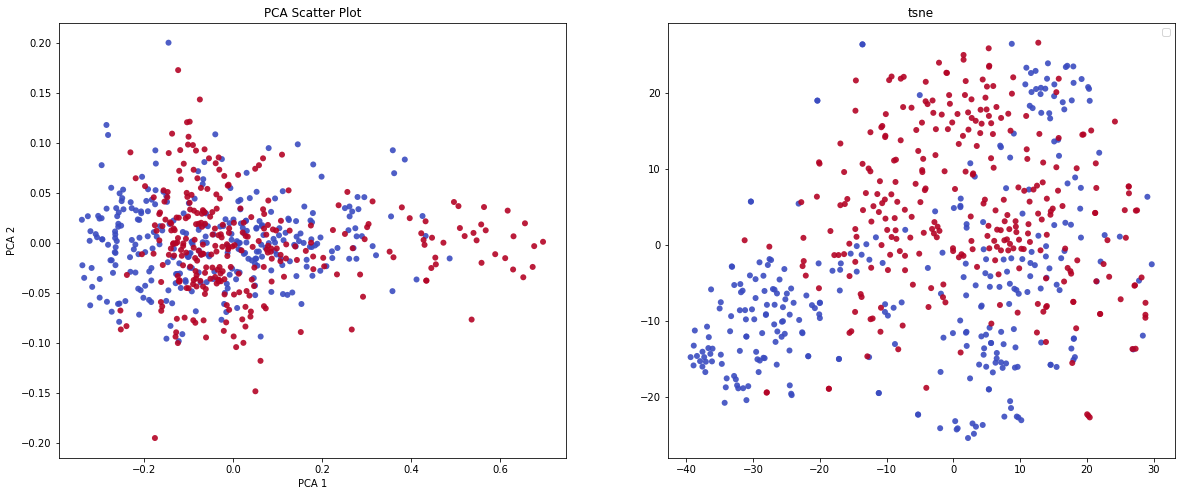

In [78]:
plt.figure(figsize = (20,8))
plt.subplot(121)
plt.scatter(pca_2d[:,0],pca_2d[:,99], c = y_train, 
            cmap = "coolwarm", edgecolor = "None", alpha=0.9)

plt.title('PCA Scatter Plot')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.subplot(122)
# plt.scatter(K_pca_result[:,0],K_pca_result[:,99],  c = y_train, cmap = "coolwarm", edgecolor = "None", alpha=0.3)
# plt.title('kpca Scatter Plot')
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = y_train, cmap = "coolwarm", edgecolor = "None", alpha=0.9)
plt.title('tsne')
plt.legend()
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 592 samples in 0.002s...
[t-SNE] Computed neighbors for 592 samples in 0.062s...
[t-SNE] Computed conditional probabilities for sample 592 / 592
[t-SNE] Mean sigma: 0.290872
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.482407
[t-SNE] KL divergence after 2000 iterations: 1.111218
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 148 samples in 0.001s...
[t-SNE] Computed neighbors for 148 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 148 / 148
[t-SNE] Mean sigma: 0.291628
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.606895
[t-SNE] KL divergence after 1450 iterations: 0.551898


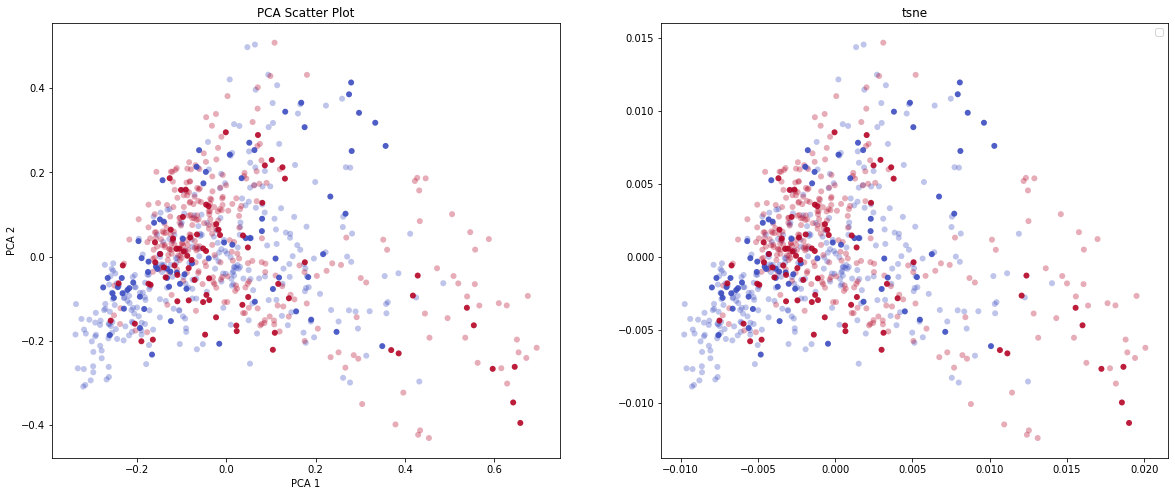

In [84]:
df= pd.DataFrame(X_train)
df_test=pd.DataFrame(X_test)
# Turn dataframe into arrays
X = df.values
X_test=df_test.values
normalizer = Normalizer().fit(X)
X= normalizer.transform(X)
X_test= normalizer.transform(X_test)
# Invoke the PCA method. Since this is a binary classification problem
# let's call n_components = 2
pca = PCA(n_components=100)
pca_2d = pca.fit_transform(X)
pca_2d_test = pca.fit_transform(X_test)

# # Invoke the TSNE method
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
tsne_results = tsne.fit_transform(X)
tsne_results_test=tsne.fit_transform(X_test)
K_pca = KernelPCA(n_components=100,kernel="poly")
K_pca_result = K_pca.fit_transform(X)
K_pca_result_test = K_pca.fit_transform(X_test)
# K_pca_result =ker_pca(X,n_components=40, gamma=1)
# K_pca_result = K_pca.fit_transform(X)

plt.figure(figsize = (20,8))
plt.subplot(121)
plt.scatter(pca_2d[:,0],pca_2d[:,1], c = y_train, 
            cmap = "coolwarm", edgecolor = "None", alpha=0.33)
plt.scatter(pca_2d_test[:,0],pca_2d_test[:,1], c = y_test, 
            cmap = "coolwarm", edgecolor = "None", alpha=0.9)

plt.title('PCA Scatter Plot')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.subplot(122)
plt.scatter(K_pca_result[:,0],K_pca_result[:,1],  c = y_train, cmap = "coolwarm", edgecolor = "None", alpha=0.33)
plt.scatter(K_pca_result_test[:,0],K_pca_result_test[:,1],  c = y_test, cmap = "coolwarm", edgecolor = "None", alpha=0.9)


# plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = y_train, cmap = "coolwarm", edgecolor = "None", alpha=0.33)
# plt.scatter(tsne_results_test[:,0],tesne_results_test[:,1],  c = y_test, cmap = "coolwarm", edgecolor = "None", alpha=0.9)
plt.title('tsne')
plt.legend()
plt.show()

In [ ]:

# tsne = TSNE(n_components=2, verbose=1, random_state=123)
# z = tsne.fit_transform(X_train) 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 592 samples in 0.002s...
[t-SNE] Computed neighbors for 592 samples in 0.068s...
[t-SNE] Computed conditional probabilities for sample 592 / 592
[t-SNE] Mean sigma: 0.208473
[t-SNE] KL divergence after 250 iterations with early exaggeration: 111.638031
[t-SNE] KL divergence after 1000 iterations: 1.509636


In [ ]:
# df = pd.DataFrame(z)
# df["y"] = y_train
# df["comp-1"] = z[:,0]
# df["comp-2"] = z[:,1]

# sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
#                 palette=sns.color_palette("hls", 2),
#                 data=df).set(title="ACP_SRC T-SNE projection") 
# plt.savefig("tsne",  transparent=True)

ValueError: ignored

2.PCA FOR TWO 

In [ ]:
# pca = PCA(n_components=3)
# pca_result = pca.fit_transform(X_train)
# df = pd.DataFrame(pca_result)

# df['pca-one'] = pca_result[:,0]
# df['pca-two'] = pca_result[:,1] 


# print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.25593415 0.1456233  0.11916711]


In [ ]:
# plt.figure(figsize=(5,5))
# sns.set_theme(style="ticks")
# sns.scatterplot(
#     x="pca-one", y="pca-two",
#     hue="y",
#     palette=sns.color_palette("Spectral",2),
#     data=df,
#     legend="full",
#     alpha=1
# ).set(title="ACP_SRC T-SNE projection")
# plt.savefig("tsne.png",  transparent=True)

ValueError: ignored

<Figure size 360x360 with 0 Axes>

In [ ]:
plt.savefig("o.png")

In [ ]:
>>> plt.savefig( ,
 transparent= ) 

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.DataFrame(X_train)
df.shape

(592, 3600)

In [ ]:
x_scaled = StandardScaler().fit_transform(df)

In [ ]:
x_scaled.shape

(592, 3600)

In [ ]:
import matplotlib.pyplot as plt 
# import seaborn as sns
 
from sklearn.decomposition import PCA
sns.set()
 
# Reduce from 4 to 3 features with PCA
pca = PCA(n_components=592)
 
# Fit and transform data
pca_transform=pca.fit_transform(x_scaled)
explained_variance_1 = numpy.var(pca_transform, axis=0)
p_explained_variance_ratio = explained_variance_1 / numpy.sum(explained_variance_1)
 
# # Bar plot of explained_variance
# plt.bar(
#     range(1,len(pca.explained_variance_)+1),
#     pca.explained_variance_,width=0.8
#     )
 
 
# plt.xlabel('PCA Feature')
# plt.ylabel('Explained variance')
# plt.title('Feature Explained Variance')
# plt.show()

In [ ]:
p_explained_variance_ratio.shape

(592,)

In [ ]:
covar_matrix=pca

In [ ]:
covar_matrix

PCA(n_components=500)

In [ ]:
plt.plot()

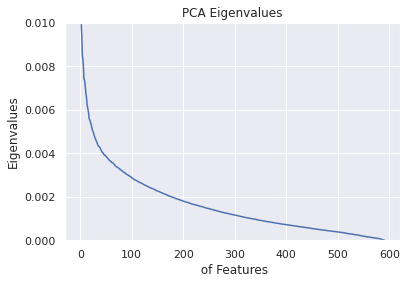

In [ ]:
plt.ylabel('Eigenvalues') 
plt.xlabel(' of Features') 
plt.title('PCA Eigenvalues') 
plt.ylim(0, 0.01) 
sns.set_theme(style="ticks")
plt.axhline (600, color='r', linestyle='-.') 
plt.plot(p_explained_variance_ratio) 
plt.show()

In [ ]:
import numpy 
transformer = KernelPCA(n_components=592, kernel='poly') # 'linear', 'poly', 'rbf', ‘sigmoid’, ‘cosine’
kpca_transform=transformer.fit_transform(x_scaled)
explained_variance = numpy.var(kpca_transform, axis=0)
k_explained_variance_ratio = explained_variance / numpy.sum(explained_variance)



In [ ]:
k_explained_variance_ratio.shape

(592,)

In [ ]:
covar_matrix_1=transformer

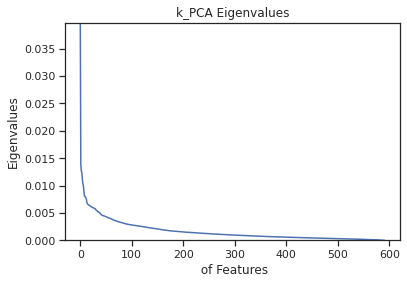

In [ ]:
plt.ylabel('Eigenvalues') 
plt.xlabel(' of Features') 
plt.title('k_PCA Eigenvalues') 
plt.ylim(0, max(k_explained_variance_ratio)) 
sns.set_theme(style="ticks")
plt.axhline (600, color='r', linestyle='-.') 
plt.plot(k_explained_variance_ratio) 
plt.show()

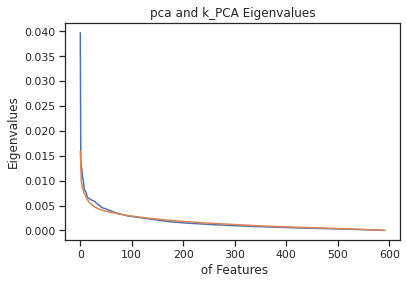

In [ ]:
p_explained_variance_ratio = explained_variance_1 / numpy.sum(explained_variance_1)
k_explained_variance_ratio = explained_variance / numpy.sum(explained_variance)
plt.plot(k_explained_variance_ratio)
plt.plot(p_explained_variance_ratio)
plt.ylabel('Eigenvalues') 
plt.xlabel(' of Features') 
plt.title('pca and k_PCA Eigenvalues') 
plt.show()

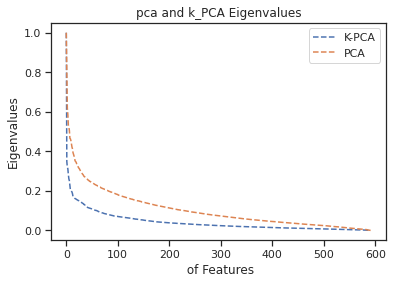

<Figure size 432x288 with 0 Axes>

In [ ]:
p_explained_variance_ratio = explained_variance_1 / numpy.sum(explained_variance_1)
k_explained_variance_ratio = explained_variance / numpy.sum(explained_variance)
plt.plot(k_explained_variance_ratio/np.max(k_explained_variance_ratio),'--',label="K-PCA")
plt.plot(p_explained_variance_ratio/np.max(p_explained_variance_ratio),'--',label="PCA")
# plt.plot(t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^')
plt.ylabel('Eigenvalues') 
plt.xlabel(' of Features') 
plt.title('pca and k_PCA Eigenvalues') 
plt.legend()
plt.show()
plt.savefig(r"pca_vs_kpca.png")

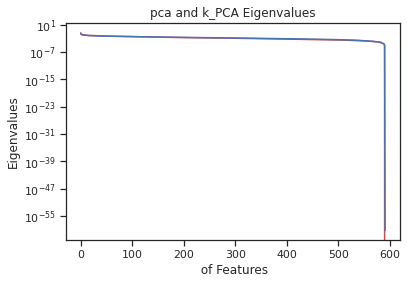

In [ ]:
p_explained_variance_ratio = explained_variance_1 / numpy.sum(explained_variance_1)
k_explained_variance_ratio = explained_variance / numpy.sum(explained_variance)
plt.semilogy(k_explained_variance_ratio,'r')
plt.semilogy(p_explained_variance_ratio,'b')
plt.ylabel('Eigenvalues') 
plt.xlabel(' of Features') 
plt.title('pca and k_PCA Eigenvalues') 
plt.show()

In [85]:
print(X_train.shape, X_test.shape)

(592, 3600) (148, 3600)


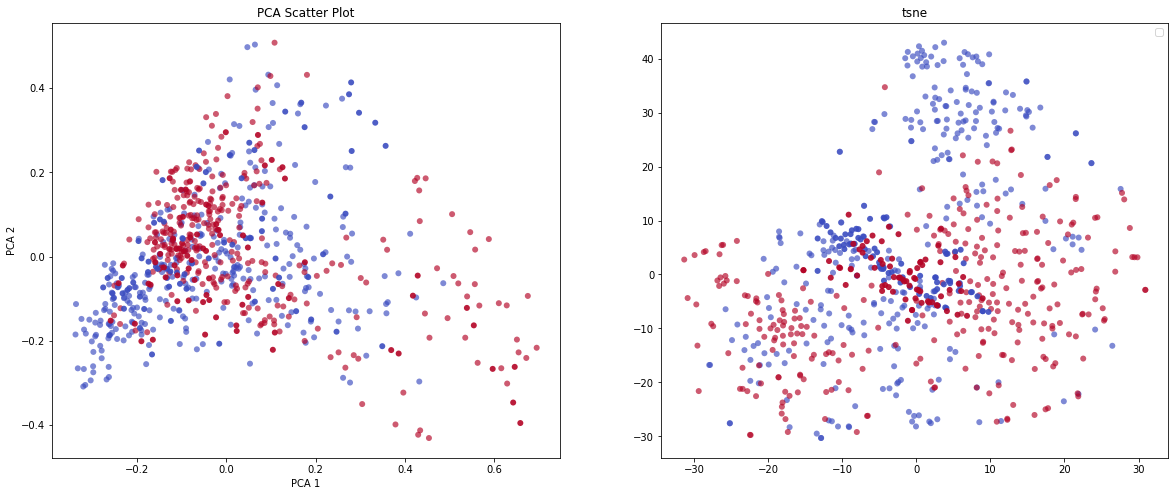

In [98]:
X = X_train
X_test=df_test.values
normalizer = Normalizer().fit(X)
X= normalizer.transform(X)
X_test= normalizer.transform(X_test)
# Invoke the PCA method. Since this is a binary classification problem
# let's call n_components = 2
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X)
pca_2d_test = pca.fit_transform(X_test)


# normalizer = Normalizer(norm='l2').fit(pca_2d)
# pca_2d= normalizer.transform(pca_2d)
# pca_2d_test= normalizer.transform(pca_2d_test)


# # Invoke the TSNE method
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X)
tsne_results_test=tsne.fit_transform(X_test)



# normalizer = Normalizer(norm='l2').fit(tsne_results)
# tsne_results= normalizer.transform(tsne_results)
# tsne_results_test= normalizer.transform(tsne_results_test)



plt.figure(figsize = (20,8))
plt.subplot(121)
plt.scatter(pca_2d[:,0],pca_2d[:,1], c = y_train, cmap = "coolwarm", edgecolor = "None", alpha=0.66)
plt.scatter(pca_2d_test[:,0],pca_2d_test[:,1], c = y_test, cmap = "coolwarm", edgecolor = "None", alpha=0.9)

plt.title('PCA Scatter Plot')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.subplot(122)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = y_train, cmap = "coolwarm", edgecolor = "None", alpha=0.66)
plt.scatter(tsne_results_test[:,0],tesne_results_test[:,1],  c = y_test, cmap = "coolwarm", edgecolor = "None", alpha=0.9)
plt.title('tsne')
plt.legend()
plt.show()